# Model Selection

@roman

Mar 16, 2025

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import yaml
import joblib
import logging
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
import shap
import h3
from catboost import CatBoostRegressor, Pool
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# show 100 columns in pandas
pd.set_option('display.max_columns', 500)
TODAY = pd.to_datetime('today')

# dir
DIR_DATA = '../../../data'
DIR_RESULTS = '../../../results'
FILE_PROPERTIES = f"{DIR_DATA}/clean/properties_shif.parquet"

In [3]:
# read config
with open("config.yaml", 'r') as stream:
    try:
        config = yaml.safe_load(stream)
        config_model = config['model']
        recaster_mappers = config['categorical_recasters']

        del config
    except yaml.YAMLError as exc:
        print(exc)

# look
config_model

{'purpose': 'prediction',
 'project_version': 2.0,
 'model_name': 'catboost',
 'hyperparameters': {'iterations': 1000,
  'learning_rate': 0.03,
  'depth': 6,
  'l2_leaf_reg': 3,
  'loss_function': 'RMSE',
  'eval_metric': 'RMSE',
  'random_seed': 42,
  'od_type': 'Iter',
  'od_wait': 20,
  'verbose': 100},
 'data': {'n_rows': 1000, 'train_size': 0.8, 'validation_size': 0.1},
 'target': {'ppsm_saleable': 'boxcox'},
 'features': {'quarters_since_first_appraisal': 'identity',
  'half_bathrooms': 'identity',
  'full_bathrooms': 'identity',
  'age_in_months': 'identity',
  'parking_lots': 'identity',
  'potable_water_service_id': 'identity',
  'lighting_service_id': 'identity',
  'sidewalk_id': 'identity',
  'conservacion_recat': 'identity',
  'elevator_service_id': 'identity',
  'is_new': 'identity',
  'equipment_id': 'identity',
  'road_materials_id': 'identity',
  'urban_proximity_id': 'identity',
  'electrical_supply_service_id': 'identity',
  'telephone_service_supply_id': 'identity',


---
# Data

In [4]:
# create function for reading data and returning X and y
def get_target(df, config):
    # read
    target_name = list(config['target'].keys())[0]
    print(target_name)

    # if ppsm2 is in target_name, then we need to calculate the target
    if 'ppsm' in target_name:
        if 'built' in target_name:
            y = df['price'] / df['built_area']
        elif 'saleable' in target_name:
            y = df['price'] / df['saleable_area']
        elif 'land' in target_name:
            y = df['price'] / df['land_area']
        else:
            print('¿hola')
            raise ValueError('Target is not supported')
    elif 'price' in target_name:
        y = df['price']
    else:
        print('¿holanjfkds')
        raise ValueError('Target is not supported')
    return y.copy()


def read_data(file, config):
    # read data
    df_work = pd.read_parquet(file)

    # filter data
    n_rows = config.get('data').get('n_rows')
    if n_rows:
        if n_rows < df_work.shape[0]:
            df_work = df_work.sample(n_rows, random_state=42).reset_index(drop=True)

    # set observation_id as index
    df_work = df_work.set_index('observation_id')

    # new features
    first_date_obs = df_work['valuation_date'].min()
    
    df_work = (
        df_work
        .assign(
            # quarters since appraisal
            quarters_since_first_appraisal=lambda x: (x['valuation_date'] - first_date_obs).dt.days / (30.4 * 3),
            # recategorizations
            is_new=lambda x: np.where(x['age_in_months'].le(1), 'new', 'used'),
            conservacion_recat=lambda x: x['conservation_status_id'].replace({7: 3.5}).astype(int),
        )
        .assign(
            is_new=lambda x: x['is_new'].astype('category'),
        )
    )

    # set target
    features_name = list(config['features'].keys())
    X = df_work.loc[:, features_name].copy()
    y = get_target(df_work, config)

    return X, y

In [5]:
# read
X, y = read_data(FILE_PROPERTIES, config_model)

# look
print(f"X shape: {X.shape}")
display(X.head())
print(f"\n y shape: {y.shape}")
display(y.head())

ppsm_saleable
X shape: (1000, 57)


,quarters_since_first_appraisal,half_bathrooms,full_bathrooms,age_in_months,parking_lots,potable_water_service_id,lighting_service_id,sidewalk_id,conservacion_recat,elevator_service_id,is_new,equipment_id,road_materials_id,urban_proximity_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,distance_to_ocean,ocean_label,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,est_socio,educa_jefe,tot_integ,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,total_viviendas,ppsm_terrain
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17eccc24-a0f8-43c0-a62c-60d2960d7c4e,14.188596,0,3,0,1,1,3,1,6,0,new,3,2,3,2,3,2,3,2,3,117,123,218,70,50000,golfo_de_mexico,0,0,0,0,0,2.724609,7.062500,3.197266,2.367188,0.373291,2.210938,81674.453125,10253.206055,31.565142,47140.269531,3390.347168,1129.408691,295.455017,2439.210693,24.312500,2.015625,4,389.655090,3491.472412,512.813477,0.279052,1.0,0.174438,1,294870,2401
c32d31e9-cbd1-4d1c-8662-a670138f5d3c,8.771930,0,2,36,1,1,3,1,5,0,used,4,3,1,2,2,4,8,1,2,90,90,100,67,10000,golfo_de_california,0,2,0,0,1,2.412109,6.699219,3.369141,2.416016,0.294434,2.044922,45830.226562,6378.166016,2.136164,32228.246094,4875.367188,2341.167236,100.593330,1632.285034,17.453125,1.905273,4,850.373962,2171.726318,202.173767,0.370282,1.0,0.023621,5,74203,8808
9c790e5f-200c-47e9-bae2-4d92ea76a8ae,10.690789,0,2,216,2,0,0,0,4,1,used,4,2,2,0,0,4,3,1,3,100,100,88,52,100000,no_ocean,0,7,0,0,0,2.929688,6.699219,3.306641,2.537109,0.349854,2.046875,69355.335938,15864.185547,0.000000,41863.468750,5750.780273,2358.816895,1410.178955,2307.441162,14.812500,2.148438,4,817.333435,5433.493164,652.357544,0.228819,2.0,0.100647,5,191514,8027
7e4d78dc-b7b6-4b29-816a-415eadd52573,6.217105,1,2,0,2,0,0,0,6,2,new,4,2,3,0,0,2,3,2,3,130,130,105,70,100000,no_ocean,0,2,0,0,1,2.291016,6.406250,4.011719,3.041016,0.194214,2.556641,64383.281250,8144.044922,0.000000,34759.871094,4147.886230,1073.762939,220.719086,1668.131348,19.140625,2.279297,4,369.851868,2780.709229,218.795563,0.178855,3.0,0.063354,5,64611,3116
21849195-6848-4340-9196-1949a9ae1153,3.695175,0,1,252,1,0,0,0,4,2,used,3,2,2,0,0,3,3,2,2,57,57,62,49,100000,no_ocean,1,2,0,0,0,2.552734,6.101562,3.544922,2.564453,0.335205,1.969727,39891.058594,6623.806152,0.000000,31047.771484,2684.412354,944.056274,319.487244,1040.406494,16.828125,2.162109,4,320.752197,2254.791748,287.948669,0.226497,2.0,0.128540,5,459742,3936



 y shape: (1000,)


observation_id
17eccc24-a0f8-43c0-a62c-60d2960d7c4e    13975.609756
c32d31e9-cbd1-4d1c-8662-a670138f5d3c    31277.777778
9c790e5f-200c-47e9-bae2-4d92ea76a8ae    22110.000000
7e4d78dc-b7b6-4b29-816a-415eadd52573    13815.384615
21849195-6848-4340-9196-1949a9ae1153     9298.245614
dtype: float64

---
# Feature Engineering

In [6]:
def feature_engineering(X, y, config, recaster_mapper=None):
    # Step 0: Create deep copies to avoid modifying original data
    index = X.index
    transformers = {}  # Dictionary to store all fitted transformers
    
    # Step 1: Check and handle missing values
    missing_values = X.isnull().sum().sum()
    if missing_values > 0:
        logger.warning(f"Warning: {missing_values} missing values detected in the dataset")
        # For production, consider implementing proper missing value handling strategy here
    
    # Step 2: Apply recaster mapping if provided
    if recaster_mapper:
        try:
            X = X.replace(recaster_mapper)
            logger.info("Applied recaster mapping successfully")
        except Exception as e:
            logger.error(f"Error applying recaster mapping: {str(e)}")
            raise ValueError(f"Failed to apply recaster mapping: {str(e)}")
    
    # Step 3: Handle categorical columns
    try:
        cols_categorical = list(set(
            X.select_dtypes(include='string').columns.tolist() +
            X.select_dtypes(include='category').columns.tolist() + 
            X.select_dtypes(include='object').columns.tolist()
        ))
        X[cols_categorical] = X[cols_categorical].astype('category')
        transformers['categorical'] = cols_categorical
        logger.info(f"Processed {len(cols_categorical)} categorical columns")
    except Exception as e:
        logger.error(f"Error processing categorical columns: {str(e)}")
        raise ValueError(f"Failed to process categorical columns: {str(e)}")
    
    # Step 4: Apply feature transformations based on config - BATCH PROCESSING
    valid_transformations = ['identity', 'log', 'sqrt', 'standardize', 'boxcox']
    X_transformed = X.copy()
    
    # Validate all transformations
    for feature, transformation in config['features'].items():
        if transformation not in valid_transformations:
            raise ValueError(f"Unsupported transformation type for feature '{feature}': '{transformation}'. "
                             f"Supported types are: {', '.join(valid_transformations)}")
    
    # Group features by transformation type
    transformation_groups = {trans_type: [] for trans_type in valid_transformations}
    
    for feature, transformation in config['features'].items():
        # Skip features not in dataset
        if feature not in X.columns:
            logger.warning(f"Feature '{feature}' not found in the dataset. Skipping transformation.")
            continue
            
        # Handle features with negative/zero values for log and boxcox
        if transformation in ['log', 'boxcox'] and (X[feature].min() <= 0 or pd.isna(X[feature]).any()):
            logger.warning(f"Feature '{feature}' contains values <= 0 or NaN. "
                           f"Cannot apply {transformation} transformation. Using standardize instead.")
            transformation = 'standardize'

        if transformation == 'sqrt' and (X[feature].min() < 0 or pd.isna(X[feature]).any()):
            logger.warning(f"Feature '{feature}' contains values < 0 or NaN. "
                            f"Cannot apply sqrt transformation. Using standardize instead.")
            transformation = 'standardize'
            
        transformation_groups[transformation].append(feature)
    
    # Process each transformation group
    for transformation, features in transformation_groups.items():
        if not features or transformation == 'identity':
            # Skip empty groups or identity transformation
            logger.info(f"Skipping '{transformation}' transformation for {len(features)} features")
            continue
            
        try:
            logger.info(f"Applying '{transformation}' transformation to {len(features)} features")
            X_transformed[features], transformer = apply_transformation(
                X[features], 
                transformation,
                feature_name=features
            )
            # for i, feature in enumerate(features):
            #     X_transformed[feature] = transformed_data[:, i]
            
            if transformer is not None:
                transformers[transformation] = transformer
                    
        except Exception as e:
            logger.error(f"Error applying {transformation} transformation to features {features}: {str(e)}")
            raise ValueError(f"Failed to apply {transformation} transformation: {str(e)}")
        
    # X_transformed.index = index
    logger.info(f"Applied transformations to features successfully")
    
    # Step 5: Transform target variable if specified
    if 'target' in config:
        target_name = list(config['target'].keys())[0]
        target_transformation = config['target'][target_name]
        
        # Validate target transformation
        if target_transformation not in valid_transformations:
            raise ValueError(f"Unsupported transformation type for target: '{target_transformation}'. "
                             f"Supported types are: {', '.join(valid_transformations)}")
        
        try:
            # Handle special case for target variable (may need series -> array conversion)
            # if isinstance(y, pd.Series):
            #     y_values = y.values.reshape(-1, 1)
            # else:
            #     y_values = y.reshape(-1, 1) if len(y.shape) == 1 else y
                
            # Skip target with negative or zero values for log and boxcox transformations
            if (target_transformation in ['log', 'boxcox', 'sqrt'] and 
                (np.min(y) <= 0 or np.isnan(y).any())):
                logger.warning(f"Target contains values <= 0 or NaN. "
                              f"Cannot apply {target_transformation} transformation. Using standardize instead.")
                target_transformation = 'standardize'
                
            y_transformed, target_transformer = apply_transformation(
                y.to_frame(),
                target_transformation,
                feature_name=target_name
            )
            y_transformed = pd.Series(y_transformed.flatten(), index=y.index)
            
            if target_transformer is not None:
                transformers["target"] = target_transformer
                
            logger.info(f"Applied '{target_transformation}' transformation to target variable")
            
        except Exception as e:
            logger.error(f"Error transforming target variable: {str(e)}")
            raise ValueError(f"Failed to transform target variable: {str(e)}")
    else:
        logger.warning("No target transformation specified in config")
    
    return X_transformed, y_transformed, transformers


def apply_transformation(data, transformation_type, feature_name=None):
    name_info = f" for '{feature_name}'" if feature_name else ""
        
    if transformation_type == 'identity':
        return data, None
    
    elif transformation_type == 'log':
        # apply log transformation
        transformed_data = np.log(data)
        # standardize
        transformer = StandardScaler()
        transformed_data = transformer.fit_transform(transformed_data)

        return transformed_data, transformer
    
    elif transformation_type == 'sqrt':
        # apply sqrt transformation
        transformed_data = np.sqrt(data)
        # standardize
        transformer = StandardScaler()
        transformed_data = transformer.fit_transform(transformed_data)
        return transformed_data, transformer
        
    elif transformation_type == 'standardize':
        transformer = StandardScaler()
        transformed_data = transformer.fit_transform(data)
        return transformed_data, transformer
        
    elif transformation_type == 'boxcox':
        transformer = PowerTransformer(method='box-cox', standardize=True)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            transformed_data = transformer.fit_transform(data)
        return transformed_data, transformer
        
    else:
        raise ValueError(f"Unsupported transformation type{name_info}: '{transformation_type}'")


def save_transformers(transformers, filepath):
    try:
        joblib.dump(transformers, filepath)
        logger.info(f"Saved transformers to {filepath}")
        return True
    except Exception as e:
        logger.error(f"Error saving transformers: {str(e)}")
        return False


def load_transformers(filepath):
    try:
        transformers = joblib.load(filepath)
        logger.info(f"Loaded transformers from {filepath}")
        return transformers
    except Exception as e:
        logger.error(f"Error loading transformers: {str(e)}")
        raise ValueError(f"Failed to load transformers: {str(e)}")


def transform_features(X, transformers):
    X_transformed = X.copy()
    
    # Apply categorical transformations
    if 'categorical' in transformers:
        cols_categorical = transformers['categorical']
        present_cols = [col for col in cols_categorical if col in X.columns]
        X[present_cols] = X[present_cols].astype('category')

    for transformation_type, features in transformers.items():
        if transformation_type == 'categorical' and len(features) > 0:
            cols_categorical = transformers['categorical']
            present_cols = [col for col in cols_categorical if col in X.columns]
            X[present_cols] = X[present_cols].astype('category')

        elif transformation_type == 'log' and len(features) > 0:
            # apply log transformation
            X_transformed[features] = np.log(X[features])
            # standardize with fitted transformer
            transformer = transformers['log']
            X_transformed[features] = transformer.transform(X_transformed[features])
        
        elif transformation_type == 'sqrt' and len(features) > 0:
            # apply sqrt transformation
            X_transformed[features] = np.sqrt(X[features])
            # standardize with fitted transformer
            transformer = transformers['sqrt']
            X_transformed[features] = transformer.transform(X_transformed[features])

        elif transformation_type == 'standardize' and len(features) > 0:
            # standardize with fitted transformer
            transformer = transformers['standardize']
            X_transformed[features] = transformer.transform(X[features])

        elif transformation_type == 'boxcox' and len(features) > 0:
            # apply boxcox transformation
            transformer = transformers['boxcox']
            X_transformed[features] = transformer.transform(X[features])

    return X_transformed


def inverse_transform_target(y_pred, transformers):
    if "target" not in transformers or transformers["target"] is None:
        return y_pred
    
    try:
        # Reshape if needed
        y_pred_reshaped = y_pred.reshape(-1, 1) if len(y_pred.shape) == 1 else y_pred
            
        inverse_transformed = transformers["target"].inverse_transform(y_pred_reshaped)
        
        # Flatten if single column
        if inverse_transformed.shape[1] == 1:
            inverse_transformed = inverse_transformed.flatten()
            
        return inverse_transformed
    except Exception as e:
        logger.error(f"Error inverse transforming target: {str(e)}")
        raise ValueError(f"Failed to inverse transform target: {str(e)}")


class FeatureTransformer:   
    def __init__(self, config, recaster_mapper=None):
        self.config = config
        self.recaster_mapper = recaster_mapper
        self.transformers_ = None
        
    def fit(self, X, y=None):
        """Fit the transformer on the training data."""
        _, _, self.transformers_ = feature_engineering(X, y, self.config, self.recaster_mapper)
        return self
        
    def transform(self, X):
        """Transform the features."""
        return transform_features(X, self.transformers_)
        
    def fit_transform(self, X, y=None):
        """Fit the transformer and transform the features."""
        X_transformed, y_transformed, self.transformers_ = feature_engineering(X, y, self.config, self.recaster_mapper)
        return X_transformed, y_transformed
        
    def get_transformers(self):
        """Get the fitted transformers."""
        return self.transformers_
    
    def save_transformers(self, filepath):
        """Save the fitted transformers to a file."""
        return save_transformers(self.transformers_, filepath)
    
    def load_transformers(self, filepath):
        """Load transformers from a file."""
        self.transformers_ = load_transformers(filepath)
        return self
    
    def inverse_transform_target(self, y_pred):
        """Inverse transform the target variable."""
        return inverse_transform_target(y_pred, self.transformers_)

In [7]:
# feature transformer
transformer = FeatureTransformer(config_model, recaster_mappers)
X_trans, y_trans = transformer.fit_transform(X, y)

# look
print(f"{'='*10} X {'='*10}")
display(X_trans.describe().T)

print(f"\n{'='*10} y {'='*10}")
display(y_trans.describe())

2025-03-16 17:10:22,493 - INFO - Applied recaster mapping successfully
2025-03-16 17:10:22,502 - INFO - Processed 12 categorical columns
2025-03-16 17:10:22,505 - INFO - Skipping 'identity' transformation for 48 features
2025-03-16 17:10:22,506 - INFO - Applying 'log' transformation to 3 features
2025-03-16 17:10:22,511 - INFO - Applying 'sqrt' transformation to 5 features
2025-03-16 17:10:22,514 - INFO - Skipping 'standardize' transformation for 0 features
2025-03-16 17:10:22,515 - INFO - Applying 'boxcox' transformation to 1 features
2025-03-16 17:10:22,524 - INFO - Applied transformations to features successfully
2025-03-16 17:10:22,541 - INFO - Applied 'boxcox' transformation to target variable


========== X ==========


,count,mean,std,min,25%,50%,75%,max
quarters_since_first_appraisal,1000.0,9.981919e+00,5.867560,0.000000,4.936952,9.824561,15.361842,19.802632
half_bathrooms,1000.0,3.450000e-01,0.508167,0.000000,0.000000,0.000000,1.000000,3.000000
full_bathrooms,1000.0,1.451000e+00,0.793870,1.000000,1.000000,1.000000,2.000000,8.000000
age_in_months,1000.0,5.234400e+01,74.686262,0.000000,0.000000,4.000000,96.000000,252.000000
parking_lots,1000.0,1.129000e+00,0.699177,0.000000,1.000000,1.000000,1.000000,8.000000
conservacion_recat,1000.0,5.001000e+00,1.012929,3.000000,4.000000,5.000000,6.000000,6.000000
level,1000.0,3.435000e+00,1.637210,0.000000,3.000000,3.000000,3.000000,21.000000
total_levels,1000.0,1.545000e+00,0.818930,1.000000,1.000000,1.000000,2.000000,14.000000
bedrooms,1000.0,2.340000e+00,0.662449,1.000000,2.000000,2.000000,3.000000,6.000000
built_area,1000.0,-4.263256e-17,1.000500,-1.792957,-0.795219,-0.220586,0.655461,4.261582



========== y ==========


count    1.000000e+03
mean     1.902762e-13
std      1.000500e+00
min     -3.778766e+00
25%     -6.115607e-01
50%     -4.334334e-02
75%      6.258258e-01
max      2.709026e+00
dtype: float64

In [8]:
# look obs
mask = X.sample(5).index

# original
display(X.loc[mask, :])
display(y.loc[mask])

# transformed
display(X_trans.loc[mask, :])
display(y_trans.loc[mask])

,quarters_since_first_appraisal,half_bathrooms,full_bathrooms,age_in_months,parking_lots,potable_water_service_id,lighting_service_id,sidewalk_id,conservacion_recat,elevator_service_id,is_new,equipment_id,road_materials_id,urban_proximity_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,distance_to_ocean,ocean_label,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,est_socio,educa_jefe,tot_integ,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,total_viviendas,ppsm_terrain
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
e1561f33-0a75-4575-9fd1-b3ae7929ef42,17.730263,0,2,0,3,1,3,1,6,0,new,3,2,2,2,2,4,8,1,2,81,83,53,70,100000,no_ocean,3,0,0,0,0,2.988281,6.515625,3.298828,2.419922,0.413574,2.248047,85772.109375,9234.152344,289.744568,49173.589844,5219.555176,1711.324463,271.472473,1750.043701,25.625000,2.255859,4,603.325500,3152.824463,680.423157,0.298390,1.0,0.156250,5,233379,7161
f24c08b0-ae5d-4f84-a094-c4334f15b1e9,7.741228,1,1,0,1,0,0,0,6,2,new,3,2,2,0,0,3,3,2,3,70,70,72,70,100000,no_ocean,0,0,0,0,0,3.103516,6.843750,3.257812,2.427734,0.292480,2.101562,69335.898438,8810.544922,64.804329,46580.128906,7327.722656,4626.658691,394.534668,2134.319824,15.578125,2.121094,4,1596.620972,3000.441406,358.256470,0.426328,1.0,0.136841,5,381992,3007
351ebec9-65d0-4841-91da-3c5acc7013a5,1.688596,0,1,132,0,0,0,0,4,2,used,4,6,2,0,0,3,3,1,1,34,34,45,49,10000,pacifico_tropical,0,0,0,0,1,1.830078,5.421875,3.500000,2.472656,0.308350,2.648438,30351.509766,3205.182861,76.223022,23130.041016,1750.645264,400.228760,134.301804,895.554260,17.437500,1.841797,4,137.110306,1092.557983,63.736759,0.139244,2.0,0.067322,5,236111,2315
85bcec6b-d526-4ac3-a2f8-b16755ac05f1,16.885965,1,1,0,1,1,3,1,6,2,new,1,2,3,2,2,3,3,2,2,77,77,116,70,100000,no_ocean,1,0,0,0,0,2.923828,7.117188,3.130859,2.351562,0.298584,2.283203,90356.000000,11170.201172,147.780579,51204.972656,6005.731934,1422.439209,245.990616,2326.163330,20.234375,2.041016,4,499.485260,3803.725098,924.110413,0.339089,1.0,0.239258,1,271693,2978
309537ae-6048-4aeb-8c90-70c8e8adc584,7.752193,1,1,0,1,0,0,0,6,2,new,4,6,2,0,0,3,3,2,2,53,53,60,60,100000,no_ocean,1,0,0,0,0,2.404297,5.167969,4.031250,2.869141,0.333252,2.503906,54481.617188,4243.148926,0.000000,34777.867188,2514.799805,783.295288,283.255676,1425.210205,17.906250,2.099609,4,269.801788,1461.530640,0.000000,0.134901,2.0,0.000000,5,26538,2756


observation_id
e1561f33-0a75-4575-9fd1-b3ae7929ef42    30831.325301
f24c08b0-ae5d-4f84-a094-c4334f15b1e9    12671.428571
351ebec9-65d0-4841-91da-3c5acc7013a5     9823.529412
85bcec6b-d526-4ac3-a2f8-b16755ac05f1    20220.779221
309537ae-6048-4aeb-8c90-70c8e8adc584    11641.509434
dtype: float64

,quarters_since_first_appraisal,half_bathrooms,full_bathrooms,age_in_months,parking_lots,potable_water_service_id,lighting_service_id,sidewalk_id,conservacion_recat,elevator_service_id,is_new,equipment_id,road_materials_id,urban_proximity_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,level,total_levels,bedrooms,built_area,saleable_area,land_area,remaining_useful_life,distance_to_ocean,ocean_label,count_supermarkets_at_1km,count_hospitals_at_5km,count_metro_at_1km,count_schools_at_1km,count_restaurants_at_1km,est_socio,educa_jefe,tot_integ,p12_64,p65mas,percep_ing,ing_cor,estim_alqu,otros_ing,gasto_mon,vivienda,alquiler,pred_cons,cuidados,antiguedad,cuart_dorm,tenencia,renta,estim_pago,pago_viv,pago_mesp,tipo_adqui,viv_usada,tipo_finan,total_viviendas,ppsm_terrain
observation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
e1561f33-0a75-4575-9fd1-b3ae7929ef42,17.730263,0,2,0,3,exists,c,concrete,6,does_not_apply,new,high,asphalt,intermediate,without_suminister,underground,apartment,8,1,2,0.226935,0.187773,-0.794909,70,100000,no_ocean,1.833984,-0.824707,-0.10968,-0.198975,-0.364746,2.988281,6.515625,3.298828,2.419922,0.413574,2.248047,85772.109375,9234.152344,289.744568,49173.589844,5219.555176,1711.324463,271.472473,1750.043701,25.625000,2.255859,4,603.325500,3152.824463,680.423157,0.298390,1.0,0.156250,5,233379,1.217858
f24c08b0-ae5d-4f84-a094-c4334f15b1e9,7.741228,1,1,0,1,does_not_apply,does_not_apply,does_not_apply,6,not_exist,new,high,asphalt,intermediate,does_not_apply,does_not_apply,house_on_condominium,3,2,3,-0.069879,-0.135128,-0.320345,70,100000,no_ocean,-0.796875,-0.824707,-0.10968,-0.198975,-0.364746,3.103516,6.843750,3.257812,2.427734,0.292480,2.101562,69335.898438,8810.544922,64.804329,46580.128906,7327.722656,4626.658691,394.534668,2134.319824,15.578125,2.121094,4,1596.620972,3000.441406,358.256470,0.426328,1.0,0.136841,5,381992,0.131209
351ebec9-65d0-4841-91da-3c5acc7013a5,1.688596,0,1,132,0,does_not_apply,does_not_apply,does_not_apply,4,not_exist,used,perfect,other,intermediate,does_not_apply,does_not_apply,house_on_condominium,3,1,1,-1.538424,-1.503979,-1.048365,49,10000,pacifico_tropical,-0.796875,-0.824707,-0.10968,-0.198975,0.560547,1.830078,5.421875,3.500000,2.472656,0.308350,2.648438,30351.509766,3205.182861,76.223022,23130.041016,1750.645264,400.228760,134.301804,895.554260,17.437500,1.841797,4,137.110306,1092.557983,63.736759,0.139244,2.0,0.067322,5,236111,-0.287770
85bcec6b-d526-4ac3-a2f8-b16755ac05f1,16.885965,1,1,0,1,exists,c,concrete,6,not_exist,new,low,asphalt,peripheral,without_suminister,underground,house_on_condominium,3,2,2,0.123945,0.045539,0.418395,70,100000,no_ocean,0.721680,-0.824707,-0.10968,-0.198975,-0.364746,2.923828,7.117188,3.130859,2.351562,0.298584,2.283203,90356.000000,11170.201172,147.780579,51204.972656,6005.731934,1422.439209,245.990616,2326.163330,20.234375,2.041016,4,499.485260,3803.725098,924.110413,0.339089,1.0,0.239258,1,271693,0.116541
309537ae-6048-4aeb-8c90-70c8e8adc584,7.752193,1,1,0,1,does_not_apply,does_not_apply,does_not_apply,6,not_exist,new,perfect,other,intermediate,does_not_apply,does_not_apply,house_on_condominium,3,2,2,-0.635638,-0.662480,-0.602755,60,100000,no_ocean,0.721680,-0.824707,-0.10968,-0.198975,-0.364746,2.404297,5.167969,4.031250,2.869141,0.333252,2.503906,54481.617188,4243.148926,0.000000,34777.867188,2514.799805,783.295288,283.255676,1425.210205,17.906250,2.099609,4,269.801788,1461.530640,0.000000,0.134901,2.0,0.000000,5,26538,-0.003031


observation_id
e1561f33-0a75-4575-9fd1-b3ae7929ef42    1.734180
f24c08b0-ae5d-4f84-a094-c4334f15b1e9    0.069289
351ebec9-65d0-4841-91da-3c5acc7013a5   -0.616933
85bcec6b-d526-4ac3-a2f8-b16755ac05f1    1.064749
309537ae-6048-4aeb-8c90-70c8e8adc584   -0.146544
dtype: float64

In [9]:
# look transformers
transformer.get_transformers()

{'categorical': ['is_new',
  'ocean_label',
  'sidewalk_id',
  'telephone_service_supply_id',
  'elevator_service_id',
  'equipment_id',
  'urban_proximity_id',
  'lighting_service_id',
  'road_materials_id',
  'electrical_supply_service_id',
  'property_type_id',
  'potable_water_service_id'],
 'log': StandardScaler(),
 'sqrt': StandardScaler(),
 'boxcox': PowerTransformer(method='box-cox'),
 'target': PowerTransformer(method='box-cox')}

In [10]:
# look for log transformers
transformer.get_transformers()['boxcox'].feature_names_in_

array(['ppsm_terrain'], dtype=object)

<Axes: ylabel='Count'>

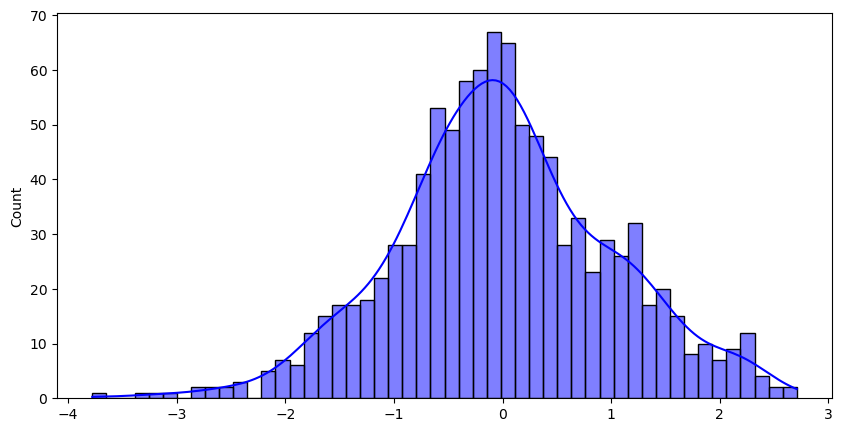

In [11]:
# plot y transformed
plt.figure(figsize=(10, 5))
sns.histplot(
    y_trans,
    kde=True,
    bins=50,
    color='blue',
    alpha=0.5,
    label='y transformed'
    
)

---
# Sandbox

In [12]:
X['built_area'].apply(np.log).std(ddof=0)

0.49173502530904883

In [13]:
np.log([
    161, 178, 108
])

array([5.08140436, 5.18178355, 4.68213123])